In [1]:
# !ls /root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/images/val

In [2]:
img_name = '000000006251.jpg'
data_split = 'train'

# img_name = '000000042188.jpg'
# data_split = 'test'
camera_positions = ['A_Pillar_Driver', 'Rear_Mirror', 'A_Pillar_Codriver']
camera_position = camera_positions[2]
img_path = f'/root/data/processed/synthetic_cabin_bw/{camera_position}/images/{data_split}/{img_name}'

In [3]:
from src.modules.human_detector.human_detector import HumanDetector

detector = HumanDetector(
    config_path='./src/modules/human_detector/config/faster_rcnn.py',
    # pretrained_path="https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/"\
    #     "faster_rcnn_r101_caffe_fpn_1x_coco/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth",
    pretrained_path="mmengine_workdir/human_detector/epoch_1.pth",
    checkpoint_path="mmengine_workdir/human_detector/epoch_1.pth",
    data_root_path='/root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/',
    device='cuda:0',
    working_directory='./mmengine_workdir/human_detector',
    log_level='CRITICAL'
)

detector.load_pretrained()
detector_result = detector.get_bbox(img_path)
bbox = detector_result['bboxes']
print(bbox)

/opt/conda/lib/python3.10/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


tensor([[  66.3972,  274.6834,  173.6328,  275.1734],
        [1272.9065,    0.0000, 1274.8711,  465.8202],
        [1270.7139,    0.0000, 1275.3563,  481.4417],
        [ 830.2717,  483.9534, 1280.0000,  484.4822],
        [1108.8027,    0.0000, 1112.5256,  429.8663],
        [1275.1088,    0.0000, 1280.0000,  456.4234],
        [1191.1027,  518.1901, 1280.0000,  545.5894],
        [ 597.9987,    0.0000,  598.8542,  517.0514],
        [1008.3578,   91.9978, 1043.9291,  105.5564],
        [1263.1261,    0.0000, 1266.5226,  534.8059],
        [ 638.9002,  483.7839, 1280.0000,  484.1216],
        [ 641.4521,  484.1980, 1280.0000,  484.5348],
        [ 633.2966,  482.4808, 1280.0000,  482.8197],
        [ 645.2905,  484.8083, 1280.0000,  485.1439],
        [ 697.9802,  503.9551, 1280.0000,  504.3178],
        [ 697.7805,  504.0991, 1280.0000,  504.4622],
        [ 699.3697,  503.4904, 1280.0000,  503.8513],
        [ 696.6507,  504.5721, 1280.0000,  504.9364],
        [ 686.0151,  493.152

/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:757: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:828: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:505: UserWarning: Warning: The text is out of bounds, the drawn text may not be in the image
  warnings.warn(


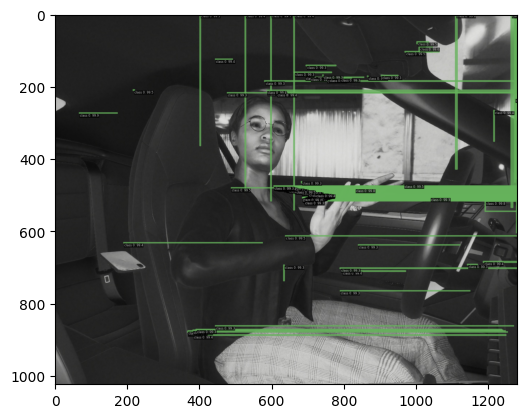

In [4]:
detector.visualise(img_path)

In [5]:
from src.modules.pose_estimator_2d.pose_estimator_2d import PoseEstimator2D

pose_estimator_2d = PoseEstimator2D(
    config_path='src/modules/pose_estimator_2d/config/hrnet.py',
    pretrained_path='https://download.openmmlab.com/mmpose/v1' \
        '/body_2d_keypoint/topdown_heatmap/coco'\
            '/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth',
    # checkpoint_path="mmengine_workdir/pose_estimator_2d/best_coco_AP_epoch_0.pth",
    checkpoint_path="mmengine_workdir/pose_estimator_2d/best_coco_AP_epoch_9.pth",
    data_root_path='/root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/',
    device='cuda:0',
    working_directory='mmengine_workdir/pose_estimator_2d',
    log_level='CRITICAL'
)

pose_estimator_2d.load_pretrained()
pose_estimator_2d_result = pose_estimator_2d.inference(img_path, bbox.detach().cpu().numpy(), bbox_format='xywh')
keypoints_2D = pose_estimator_2d_result[0].pred_instances['keypoints'][0]
print(keypoints_2D)

KeyboardInterrupt: 

wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

keypoints = pd.DataFrame(keypoints_2D, columns=['x', 'y'])

img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.scatter(keypoints['x'], keypoints['y'])
plt.show()

In [ ]:
import json
import numpy as np
with open(f'/root/data/processed/synthetic_cabin_bw/{camera_position}/annotations/person_keypoints_{data_split}.json') as f:
    data = json.loads(f.readline())

annotations = {}
for id in range(len(data['images'])):
    annotations[data['images'][id]['file_name']] = {
        'keypoints': np.array(data['annotations'][id]['keypoints']).reshape(-1, 3)[:, :2]
    }

In [ ]:
pose_estimator_2d.visualize(
    img_path=img_path,
    bboxes=bbox.tolist(),
    bbox_format='xywh',
    gt_keypoints=np.expand_dims(annotations[img_name]['keypoints'], 0)
)